In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#torch.set_default_device('cuda')

In [2]:
words = open('/kaggle/input/names-dataset/names.txt', 'r').read().splitlines()

# vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)



In [3]:
block_size = 3 #how many character are taken to predict next one
def build_dataset(words):
    inputs, labels = [],[]

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            inputs.append(context)
            labels.append(ix)
            context = context[1:] + [ix] #crop and append next character
    inputs = torch.tensor(inputs)
    labels = torch.tensor(labels)
    return inputs, labels

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
xtrain, ytrain = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xtest, ytest = build_dataset(words[n2:])

In [21]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    

    def __call__(self, x):
        #data -> layer is like data @ layer
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters trained with backpropagation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

ch_embed_dim = 10
n_hidden = 100

C = torch.randn((vocab_size, ch_embed_dim))
layers = [
    Linear(ch_embed_dim * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),                  BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),                  BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),                  BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),                  BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),                BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #make last layer less confindent 
    layers[-1].gamma *= 0.1
    #for all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True

47551


In [22]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    #construct batch
    ix = torch.randint(0, xtrain.shape[0], (batch_size,))
    xbatch, ybatch = xtrain[ix], ytrain[ix]

    #forward pass 
    embed = C[xbatch]
    x = embed.view(embed.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, ybatch)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    learn_rate = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= learn_rate * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(learn_rate*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    if i >= 1000:
        break 

      0/ 200000: 3.2876


layer 2 (      Tanh): mean +0.00, std 0.63, saturated 3.16%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated 2.56%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated 2.28%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated 2.50%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated 2.41%


Text(0.5, 1.0, 'activation distribution')

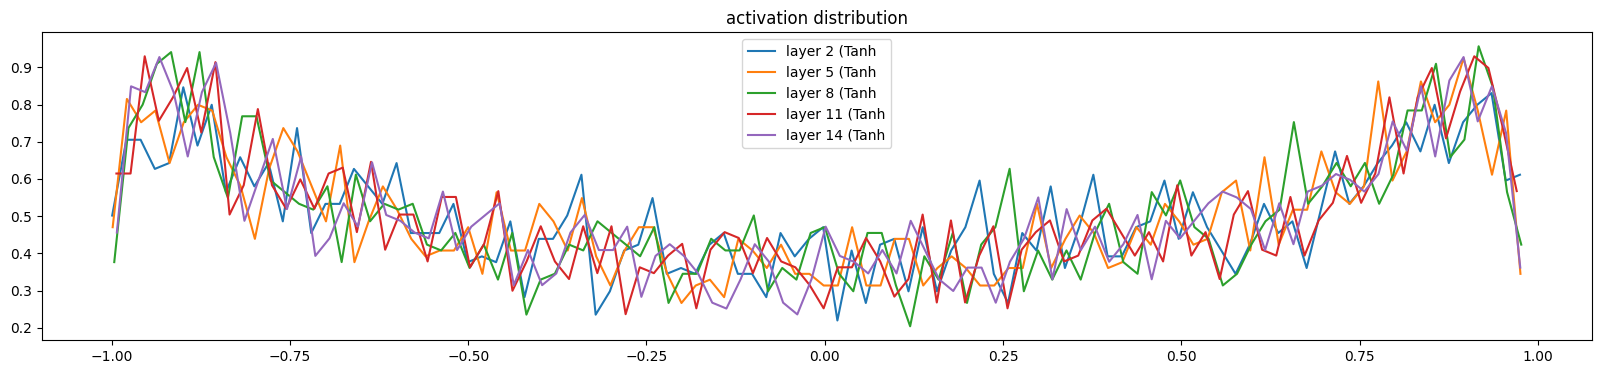

In [23]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), 
                                                                           t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.831173e-03
layer 5 (      Tanh): mean +0.000000, std 3.300565e-03
layer 8 (      Tanh): mean -0.000000, std 2.861872e-03
layer 11 (      Tanh): mean +0.000000, std 2.791541e-03
layer 14 (      Tanh): mean -0.000000, std 2.640092e-03


Text(0.5, 1.0, 'gradient distribution')

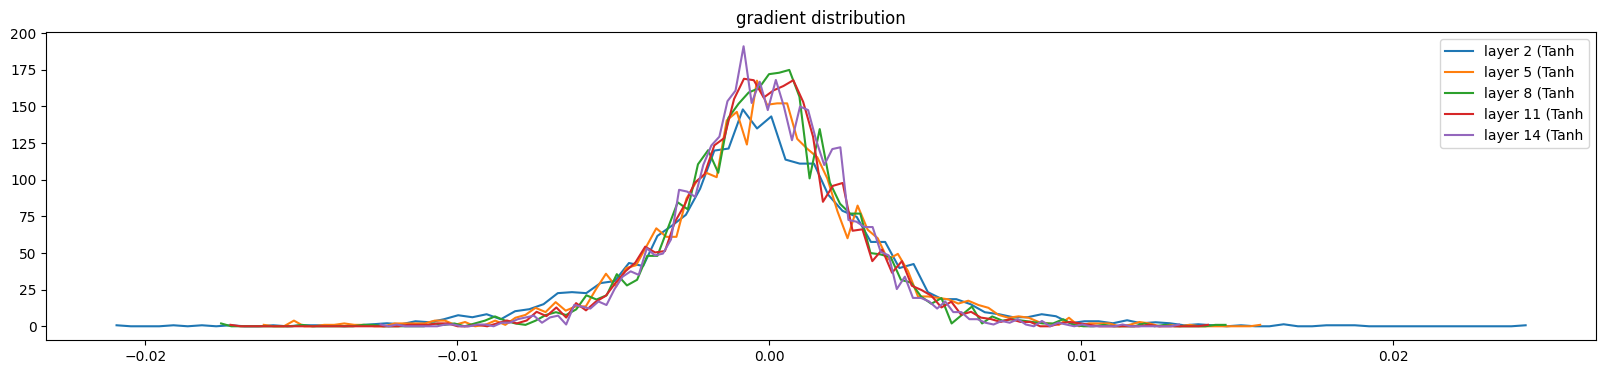

In [24]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()) )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.032619e-02 | grad:data ratio 1.050120e-02
weight  (30, 100) | mean +0.000089 | std 9.389113e-03 | grad:data ratio 3.099279e-02
weight (100, 100) | mean +0.000063 | std 7.119793e-03 | grad:data ratio 4.213170e-02
weight (100, 100) | mean -0.000063 | std 6.543424e-03 | grad:data ratio 3.857066e-02
weight (100, 100) | mean +0.000015 | std 6.121419e-03 | grad:data ratio 3.723762e-02
weight (100, 100) | mean -0.000010 | std 5.740095e-03 | grad:data ratio 3.417939e-02
weight  (100, 27) | mean -0.000053 | std 1.066887e-02 | grad:data ratio 6.475987e-02


Text(0.5, 1.0, 'weights gradient distribution')

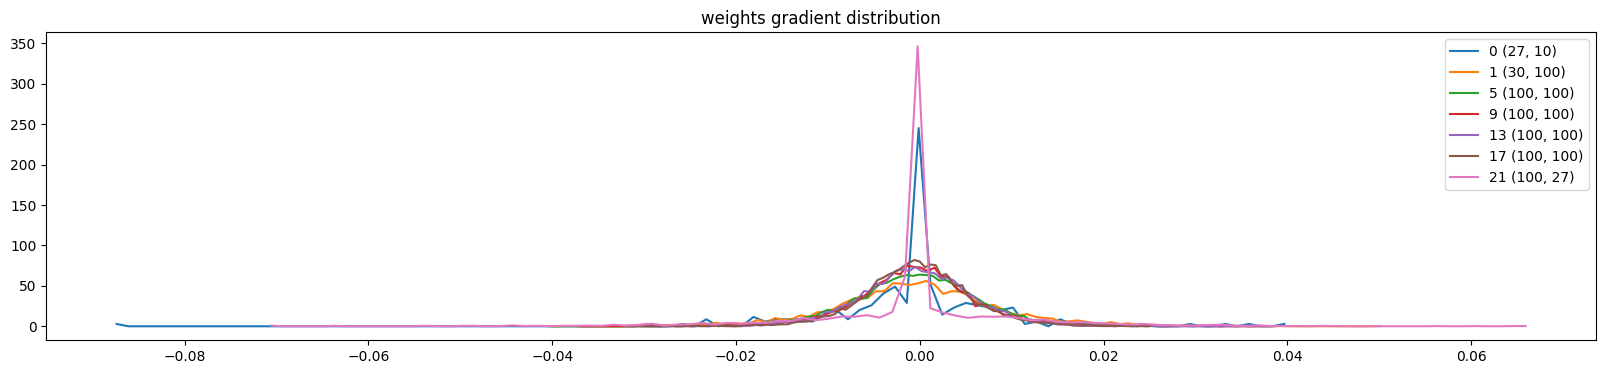

In [25]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), (t.std() / p.std())))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

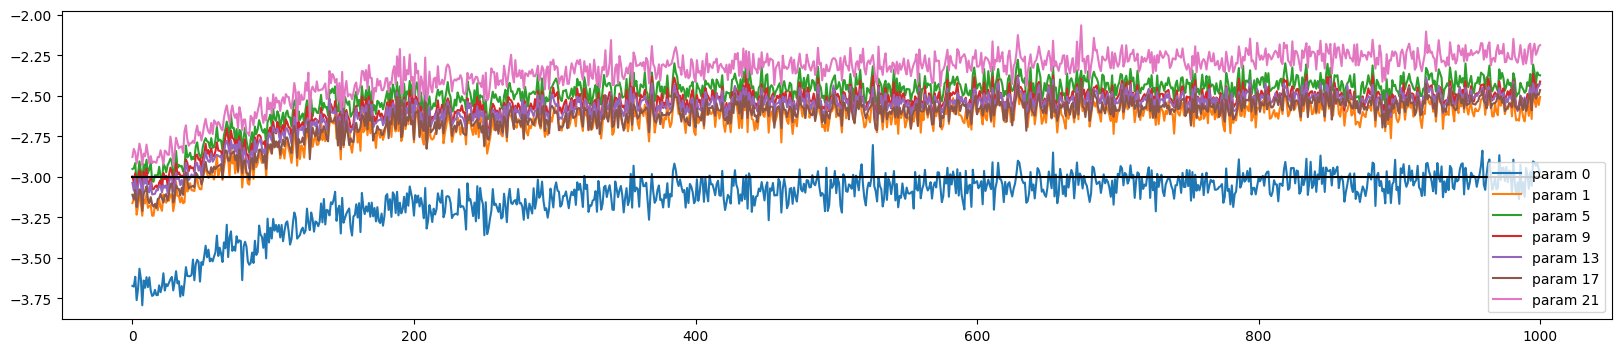

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)
